# Approach Detection Model

## Import libraries and load model

In [75]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib # for reading files

# Load the model
model = tf.keras.models.load_model('models/model_approach.h5')

# Display the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

## Visualizing Filters

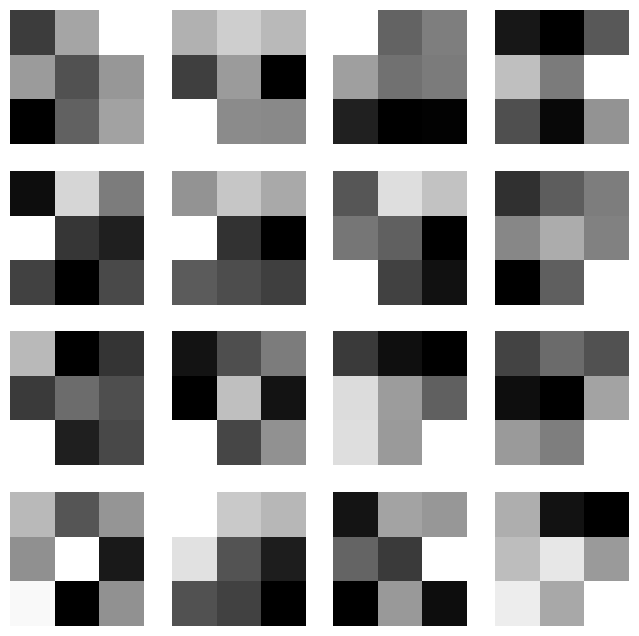

In [76]:
# Get the weights of the first convolutional layer
first_conv_layer = model.get_layer('conv2d')  # Adjust the index based on your model
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to [0, 1] for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the filters
n_filters = filters.shape[-1]
plt.figure(figsize=(8, 8))
for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(4, 4, i + 1)  # Adjust dimensions based on the number of filters
    plt.imshow(f[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


It seems that this layer is focusing more on light and dark patterns.

## Visualizing Feature maps
Feature maps are the result of applying filters to the input image. They highlight the parts of the image that the filters respond to.

In [77]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_approach_training_2024_05_19\\categories')
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.

img_height = 180 # Using the actual sizes takes too long for training.
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21306 files belonging to 2 classes.
Using 17045 files for training.


1/1 [==============================] - 0s 21ms/step


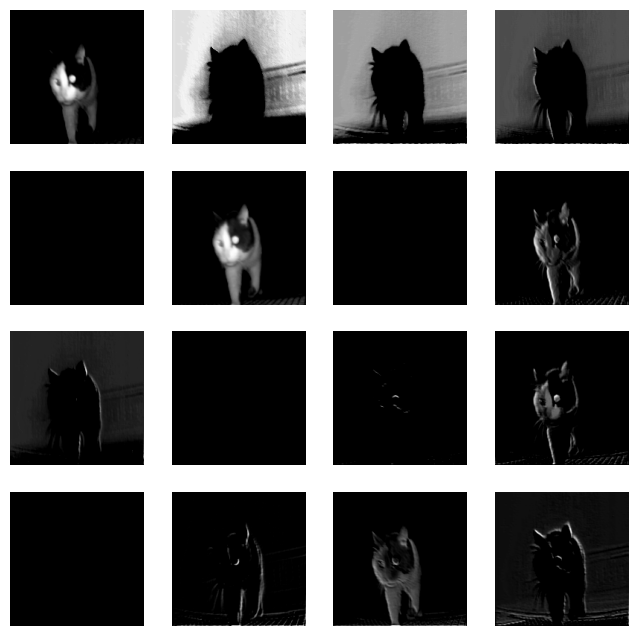

In [78]:
from tensorflow.keras.models import Model

# Create a new model that outputs the feature maps of the first conv layer
feature_map_model = Model(inputs=model.inputs, outputs=model.get_layer('conv2d').output)

# Select an image from the dataset
for images, _ in train_ds.take(1):
    img = images[0:1]

# Get the feature maps
feature_maps = feature_map_model.predict(img)

# Plot the feature maps
n_features = feature_maps.shape[-1]
plt.figure(figsize=(8, 8))
for i in range(n_features):
    plt.subplot(4, 4, i + 1)  # Adjust dimensions based on the number of feature maps
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')
    plt.axis('off')
plt.show()


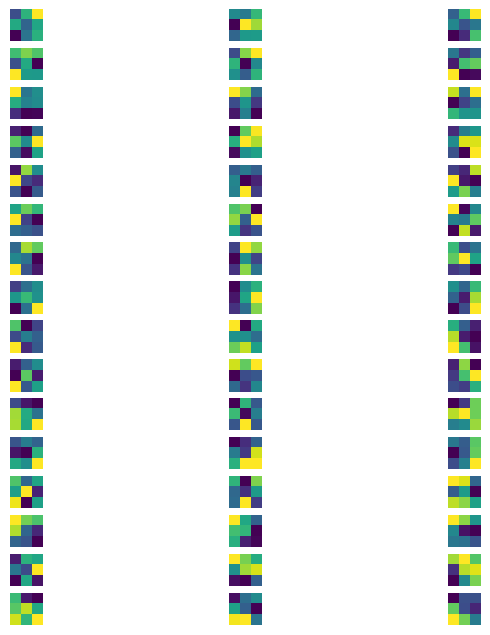

In [79]:
import matplotlib.pyplot as plt

# Get the weights of the first convolutional layer
first_conv_layer = model.get_layer('conv2d')
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to [0, 1] for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[-1]  # Number of filters
n_channels = filters.shape[-2]  # Number of channels in each filter

# Plot the filters
plt.figure(figsize=(8, 8))
for i in range(n_filters):
    for j in range(n_channels):
        ax = plt.subplot(n_filters, n_channels, i * n_channels + j + 1)
        plt.imshow(filters[:, :, j, i], cmap='viridis')
        plt.axis('off')
plt.show()


each column respresents one of the three color channels for each filter

## Grad-CAM Heatmap
Grad-CAM (Gradient-weighted Class Activation Mapping) provides a visual explanation for predictions made by the model. It highlights regions in the image that are important for the prediction.

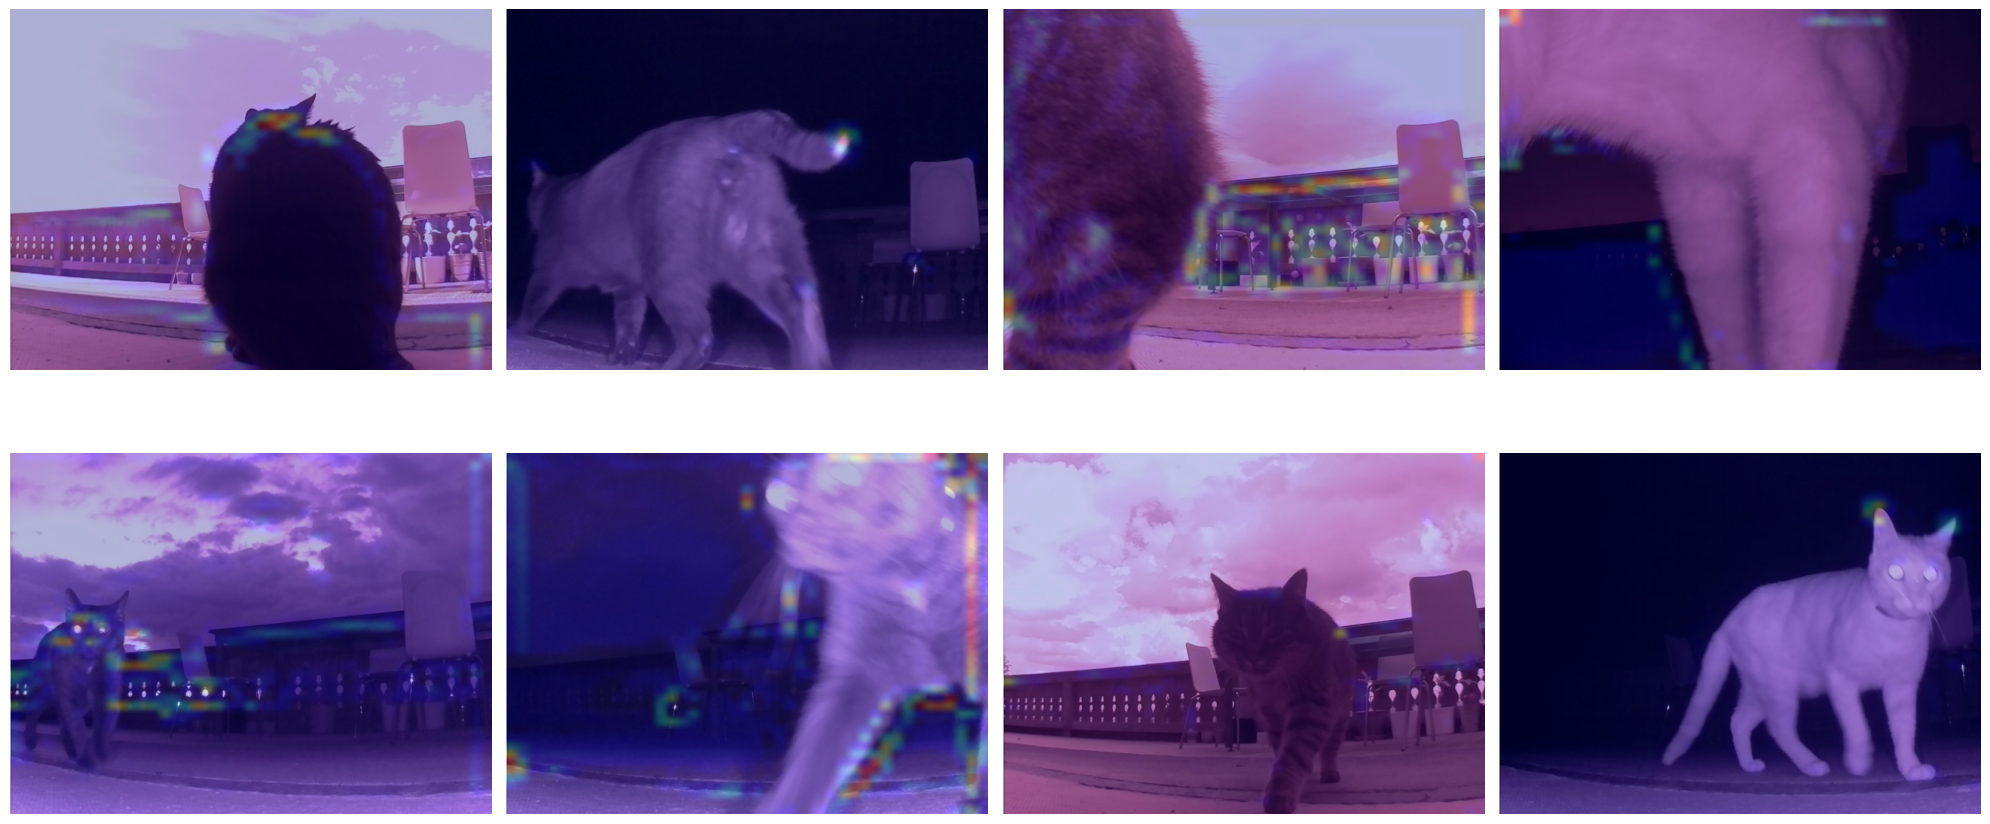

In [80]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Function to load and preprocess the image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM heatmap on image
def display_gradcam(img_path, heatmap, alpha=0.4, ax=None):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    if ax:
        ax.imshow(superimposed_img)
        ax.axis('off')
    else:
        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.show()

# Paths to example images of different classes
img_paths = [
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_06_11_02_37_936652_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_07_01_57_14_593121_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_06_17_24_36_433898_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_08_04_58_49_309894_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_08_04_58_49_309894_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_09_04_53_08_223964_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_07_16_47_17_735764_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_09_03_35_08_856693_cat.jpg'
]

# Size of images expected by the model
img_size = (180, 180)

# Layer name of the last convolutional layer
last_conv_layer_name = "conv2d_2"  # Update the layer name based on your model

# Plotting the Grad-CAM for each image in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, img_path in enumerate(img_paths):
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)
    display_gradcam(img_path, heatmap, alpha=0.4, ax=axes[i])
plt.tight_layout()
plt.show()


The model seems to focus too much on the background, i.e., the veranda. One solution would be to crop the images in the previous step to the "cat area". Or just more training data to induce more variability in the backgrounds.

## LIME
Local Interpretable Model-agnostic Explanations

In [81]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image


print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.10.0


In [82]:
# Load model
model = tf.keras.models.load_model('models/model_approach.h5')

1/1 [==============================] - 0s 39ms/step
0.82108873


Text(0.5, 1.0, 'Approaching Score: 0.82')

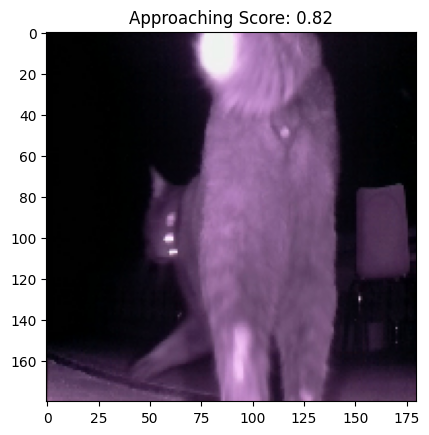

In [83]:
# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_07_01_57_12_963533_cat.jpg'
img_height = 180
img_width = 180

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)

print(predictions[0][0])

# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title('Approaching Score: {:.2f}'.format(predictions[0][0]))

This cat is obviously not approaching, but the model classifies it as approaching for with  52% confidence

In [84]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()


In [85]:
# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 26/1000 [00:00<00:03, 259.95it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 52/1000 [00:00<00:04, 221.25it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 80/1000 [00:00<00:04, 214.72it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 107/1000 [00:00<00:03, 233.62it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 131/1000 [00:00<00:04, 214.24it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 160/1000 [00:00<00:03, 218.33it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 183/1000 [00:00<00:03, 219.75it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 210/1000 [00:00<00:03, 215.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 240/1000 [00:01<00:03, 217.55it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 270/1000 [00:01<00:03, 218.19it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 300/1000 [00:01<00:03, 223.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 224.63it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 222.92it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 224.12it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 224.79it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 450/1000 [00:02<00:02, 224.75it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 480/1000 [00:02<00:02, 227.04it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 503/1000 [00:02<00:02, 227.19it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 530/1000 [00:02<00:02, 221.32it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 222.92it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 225.30it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 227.74it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 649/1000 [00:02<00:01, 243.34it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 674/1000 [00:03<00:01, 227.66it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 700/1000 [00:03<00:01, 217.92it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 730/1000 [00:03<00:01, 218.81it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 760/1000 [00:03<00:01, 221.35it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 783/1000 [00:03<00:00, 222.38it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 810/1000 [00:03<00:00, 216.69it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 836/1000 [00:03<00:00, 227.77it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 217.08it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 220.61it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 920/1000 [00:04<00:00, 221.08it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 950/1000 [00:04<00:00, 223.50it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 980/1000 [00:04<00:00, 226.47it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 1000/1000 [00:04<00:00, 223.44it/s]


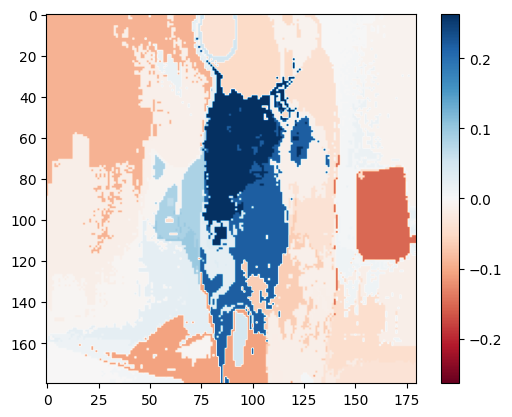

In [86]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

Yeah we need to crop the image. It get's too much confusion from the background

# Cat Classification

Notebook run using keras: 2.10.0
1/1 [==============================] - 0s 42ms/step
[ 0.47466406  0.29648685 -0.87443393]
tf.Tensor([0.47703815 0.39918274 0.1237791 ], shape=(3,), dtype=float32)
This image most likely belongs to Hali with a 47.70 percent confidence.


Text(0.5, 1.0, 'Most likely Hali with a 47.70 % confidence')

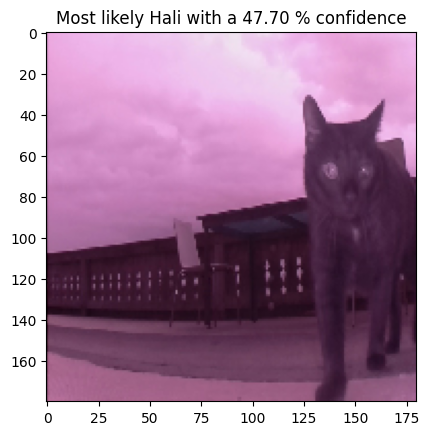

In [87]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

# Load model
model = tf.keras.models.load_model('models/model_hrs6.h5')

# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_h\\2024_06_08_21_25_13_832330_cat.jpg'
img_height = 180
img_width = 180
class_names = ['Hali', 'Rex', 'Simba']

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)
print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title("Most likely {} with a {:.2f} % confidence"
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 30/1000 [00:00<00:04, 231.77it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 60/1000 [00:00<00:04, 228.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 86/1000 [00:00<00:03, 240.48it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 111/1000 [00:00<00:04, 220.23it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 219.76it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 221.76it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 200/1000 [00:00<00:03, 223.58it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 230/1000 [00:01<00:03, 220.18it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 260/1000 [00:01<00:03, 221.83it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 290/1000 [00:01<00:03, 224.21it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 320/1000 [00:01<00:03, 225.39it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 225.86it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 224.59it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 410/1000 [00:01<00:02, 227.43it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 227.89it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 468/1000 [00:02<00:02, 240.61it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 493/1000 [00:02<00:02, 226.18it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 516/1000 [00:02<00:02, 226.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 540/1000 [00:02<00:02, 213.95it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 216.87it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 600/1000 [00:02<00:01, 220.08it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 222.33it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 222.34it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 690/1000 [00:03<00:01, 222.77it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 720/1000 [00:03<00:01, 224.04it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 750/1000 [00:03<00:01, 223.37it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 223.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 810/1000 [00:03<00:00, 220.24it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████▍ | 840/1000 [00:03<00:00, 220.32it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 870/1000 [00:03<00:00, 222.61it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 900/1000 [00:04<00:00, 223.83it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 930/1000 [00:04<00:00, 223.83it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 960/1000 [00:04<00:00, 222.21it/s]

1/1 [==============================] - 0s 11ms/step


 99%|█████████▉| 990/1000 [00:04<00:00, 225.19it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 1000/1000 [00:04<00:00, 224.05it/s]


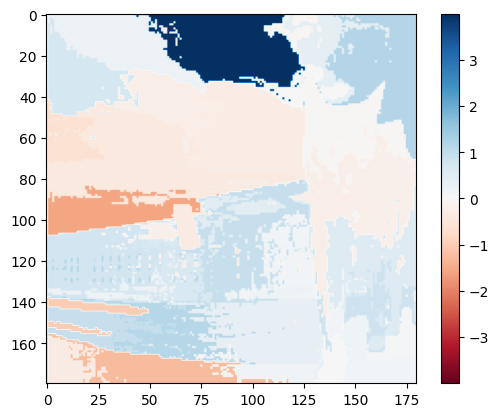

In [88]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)


#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Prey Detection: LIME

In [1]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.10.0


c:\Users\mirela\.conda\envs\tf3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model
model = tf.keras.models.load_model('models/model_prey.h5')

1/1 [==============================] - 0s 12ms/step
0.43812868


Text(0.5, 1.0, 'Prey Score: 0.44')

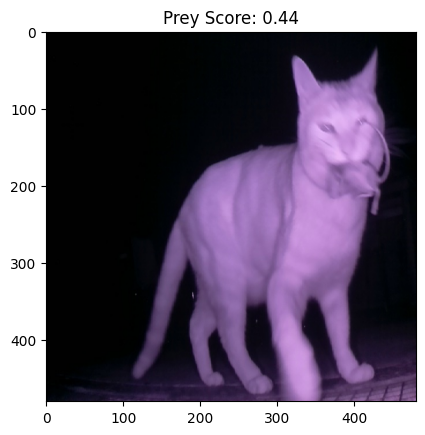

In [6]:
# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\2024_05_12_01_07_24_222692_cat_mouth_detected.jpg'
img_height = 480
img_width = 480

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)

print(predictions[0][0])

# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title('Prey Score: {:.2f}'.format(predictions[0][0]))

In [7]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)

  1%|          | 9/1000 [00:00<00:11, 88.35it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 18/1000 [00:00<00:16, 60.65it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▎         | 25/1000 [00:00<00:18, 52.83it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 31/1000 [00:00<00:20, 48.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 48/1000 [00:00<00:16, 56.29it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 54/1000 [00:01<00:18, 51.15it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 68/1000 [00:01<00:17, 54.77it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 74/1000 [00:01<00:18, 50.25it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 89/1000 [00:01<00:16, 55.81it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 95/1000 [00:01<00:17, 51.51it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 109/1000 [00:02<00:15, 55.81it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 115/1000 [00:02<00:17, 51.35it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 121/1000 [00:02<00:18, 48.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 138/1000 [00:02<00:15, 56.23it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 144/1000 [00:02<00:16, 51.15it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 158/1000 [00:03<00:15, 53.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 164/1000 [00:03<00:16, 49.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 179/1000 [00:03<00:14, 55.66it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 185/1000 [00:03<00:16, 50.89it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 199/1000 [00:03<00:14, 55.19it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 205/1000 [00:03<00:15, 50.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 219/1000 [00:04<00:14, 54.97it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 225/1000 [00:04<00:15, 50.59it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 239/1000 [00:04<00:13, 54.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 245/1000 [00:04<00:14, 50.98it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 259/1000 [00:05<00:13, 54.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 265/1000 [00:05<00:14, 50.21it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 271/1000 [00:05<00:15, 47.97it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 289/1000 [00:05<00:12, 57.11it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 295/1000 [00:05<00:13, 51.99it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 309/1000 [00:05<00:12, 54.84it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 315/1000 [00:06<00:13, 50.61it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 321/1000 [00:06<00:14, 47.33it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 338/1000 [00:06<00:12, 54.91it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 344/1000 [00:06<00:13, 50.31it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 358/1000 [00:06<00:11, 54.18it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 364/1000 [00:07<00:12, 50.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 378/1000 [00:07<00:11, 54.80it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 384/1000 [00:07<00:12, 50.01it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 398/1000 [00:07<00:10, 54.81it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 404/1000 [00:07<00:11, 50.10it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 419/1000 [00:08<00:10, 56.61it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 425/1000 [00:08<00:11, 51.91it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 439/1000 [00:08<00:10, 55.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 445/1000 [00:08<00:10, 50.61it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 459/1000 [00:08<00:09, 54.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 465/1000 [00:09<00:10, 49.95it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 479/1000 [00:09<00:09, 54.47it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 485/1000 [00:09<00:10, 49.98it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 499/1000 [00:09<00:09, 55.05it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 505/1000 [00:09<00:09, 50.35it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 511/1000 [00:10<00:10, 47.67it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 529/1000 [00:10<00:08, 56.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 535/1000 [00:10<00:09, 50.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 549/1000 [00:10<00:08, 55.38it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 555/1000 [00:10<00:08, 50.40it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 569/1000 [00:11<00:07, 55.21it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 575/1000 [00:11<00:08, 50.72it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 589/1000 [00:11<00:07, 54.18it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 595/1000 [00:11<00:08, 49.83it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 609/1000 [00:11<00:07, 54.16it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 615/1000 [00:12<00:07, 49.93it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 629/1000 [00:12<00:06, 53.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 635/1000 [00:12<00:07, 49.67it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 649/1000 [00:12<00:06, 54.04it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 655/1000 [00:12<00:06, 49.84it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 661/1000 [00:12<00:07, 47.02it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 678/1000 [00:13<00:05, 55.18it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 684/1000 [00:13<00:06, 50.50it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 698/1000 [00:13<00:05, 55.06it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 704/1000 [00:13<00:05, 50.68it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 719/1000 [00:14<00:04, 56.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 725/1000 [00:14<00:05, 50.27it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 739/1000 [00:14<00:04, 54.90it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 745/1000 [00:14<00:05, 50.20it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 751/1000 [00:14<00:05, 47.31it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 769/1000 [00:15<00:04, 56.64it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 775/1000 [00:15<00:04, 52.46it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 789/1000 [00:15<00:03, 55.78it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 795/1000 [00:15<00:04, 50.95it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 809/1000 [00:15<00:03, 55.52it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 815/1000 [00:15<00:03, 50.08it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 829/1000 [00:16<00:03, 55.30it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 835/1000 [00:16<00:03, 50.75it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 849/1000 [00:16<00:02, 55.16it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 855/1000 [00:16<00:02, 50.72it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 869/1000 [00:17<00:02, 54.98it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 875/1000 [00:17<00:02, 50.85it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 881/1000 [00:17<00:02, 47.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 899/1000 [00:17<00:01, 56.66it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 905/1000 [00:17<00:01, 50.80it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 911/1000 [00:17<00:01, 47.53it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 928/1000 [00:18<00:01, 54.86it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 934/1000 [00:18<00:01, 50.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 949/1000 [00:18<00:00, 56.14it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 955/1000 [00:18<00:00, 51.27it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 969/1000 [00:18<00:00, 55.23it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 975/1000 [00:19<00:00, 51.23it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 981/1000 [00:19<00:00, 48.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 999/1000 [00:19<00:00, 56.98it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 1000/1000 [00:19<00:00, 50.95it/s]


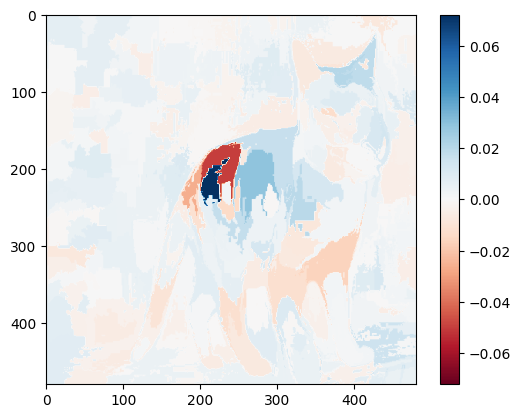

In [8]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()